# Linked Cell Algorithm  <div style="text-align: right"> **[Total : 34 points]** </div>

## Classical Linked-Cell Algorithm

We discussed in the first worksheet that force calculation takes most of the time during molecular dynamics simulation. Therfore, in order to speed up the simulation, we need to improve the process of force calculation. <br/><br/>
The naive direct particle to particle interaction has complexity $\mathcal{O}(N^2)$. We will now have a look at methods that will reduce the complexity. <br/>
In this assignment you will work with **Linked-Cell Algorithm**. There are many short range potentials like LJ potential (as shown in the figure below). For each molecule, an influence volume (closed sphere) with cut-off radius $r_c$ can be assumed. Every molecule outside this influence volume is neglected. 
<p align="center">
<img src="./figures/LJforce.png"
     alt="LJ force"
     width="356" height="356"/>
</p>
Therfore, during the calculation of force we need to calculate to consider the molecules within the sphere only. Since the total number of molecule within the sphere is small compared to the total number of molcules, the complexity of this algortihm is $\mathcal{O}(N)$. <br/><br/>
In the Linked-Cell Algorithm, you divide your domain into cells. The size of each cell is equal to the cut-off radius $r_c$. For every cell, there is a list of neighboring cells. The neighboring cells are those that are in direct contact with the current cell. In the figure below, the neighboring cells of the cell in red are shown in yellow and orange in color.
<p align="center">
<img src="./figures/linked-cell1.png"
     alt="linked-cells"
     width="256" height="256"/>
</p>
Let us try to implement this algorithm first.

## Variable Linked-Cell
In linked-cell algorithm, we might interact with particles that are outside the cut-off radius. We can decrease these interactions using **Variable Linked-Cell Algorithm**. In variable linked-cell, the length of each cell is $\frac{r_c}{a}$, where $a$ is generally an integer. We will call this as variable linked cell parameter. The neighboring cell of any cell will consist of those cells which might partially or completely fall within the cut-off sphere for any point inside the concerned cell. An example of variable linked-cell is shown below:
<p align="center">
<img src="./figures/variable-linked-cells.png"
     alt="variable-linked-cells"
     width="1024" height="1024"/>
</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, patches
import time
from itertools import product
import utils
import particle as pr
import cell_1
import cell_2
# hey I'm still learning git

We define the function **lj_potential** to calculate the Lennard Jones Potential. Then we calculate the potential between two particles separated at a distance of $0.1$, $0.2$, $0.3$ and $0.4$ respectively. Notice the rapid decay of potential. <br/>
__NOTE__: The function **lj_potential** is implemented in file _utils.py_ which is inside the same directory as this iPython notebook.

In [4]:
print("Potential when distance is 0.1:  ", utils.lj_potential(0.01))
print("Potential when distance is 0.1:  ", utils.lj_potential(0.1))
print("Potential when distance is 0.2:  ", utils.lj_potential(0.2))
print("Potential when distance is 0.3:  ", utils.lj_potential(0.3))
print("Potential when distance is 0.4:  ", utils.lj_potential(0.4))
#hei I'm learning git

Potential when distance is 0.1:   989999999.9999998
Potential when distance is 0.1:   -9.998999999999997
Potential when distance is 0.2:   -0.15624975585937495
Potential when distance is 0.3:   -0.013717419243152115
Potential when distance is 0.4:   -0.0024414061903953546


### Definition of class Particle

Now we define the class **Point** and **Particle** to define the properties of a particular particle. 
<br/>
Open file _particle.py_ and go through the implementation of both the classes and understand the implementation of both.

Let us create $N$ particles and plot their position.

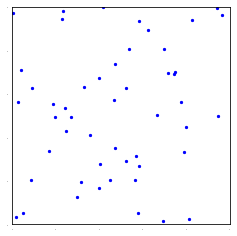

In [14]:
domain = 1.0
N = 50
def get_list_particles(N):
    list_particles = []
    for i in range(N):
        list_particles.append(pr.Particle(domain=domain))
    return list_particles

list_particles = get_list_particles(N)
    
# plotting
ax = plt.gca()
for particle in list_particles:
    particle.plot(color='b', s=5)
ax.tick_params(axis='both',labelsize=0, length = 0)
plt.xlim(left=0, right=domain)
plt.ylim(bottom=0, top=domain)
ax.set_aspect('equal', adjustable='box')
plt.show()

We will implement a class that defines **cell** in two different ways. We will call those two implementations as **Cell_1** and **Cell_2**. Both classes should be child classes of **Cell**. Let us discuss the first implementation(**Cell_1**).

## Definition of class Cell_1

There are five member variables of class **Cell_1**
1. __cell_center__: Array of size two which contains the x and y coordinates of the center of the cell
2. __side_length__: The side length of the cell
3. __a__: Variable linked cell parameter
4. __particle_index__: List that contains the indices of particles (inside the list __list_particles__) which fall inside the cell
5. __neighbor_cell_index__: List that contain the indices of cells which are neighbors of current cell. These indices represents the location of cell in the list named **list_cells**. **list_cells** is list of all cells inside the domain. We will explain **list_cells** in detail later.
6. __cell_index__: Index of current cell in __list_cells__.

<p align="center">
<img src="./figures/cell_1_class.png"
     alt="cell_1_class"
     width="512" height="512"/>
</p>

For example: for the figure shown above, the cell has particle number 9 and 11. The neighboring cell indices are 3, 4, 7, 8, 9, 11, 12, 13.

**Constructor of class**: In order to create an object of class __Cell_1__, one need to provide following parameters:
1. lx : x-coordinate of bottom left corner of the cell
2. ly : y-coordinate of bottom left corner of the cell
3. r_c : Cut-off radius
4. cell_index : Index of cell in list_cells
5. neighbor_delta_coordinate : List of numpy array(of size 2). We will provide detailed explanation of this variable in the first task.
6. a : Variable linked-cell parameter (default value 1)
7. domain : Size of domain (default value 1.0)
            

Before we move further and describe the member functions of class **Cell_1**, we take a short detour and define **list_cells**. <br/>
**list_cells**:  This is list of all the cells (object of type Cell_1) inside the domain. The cells are arranged in row major order. This means we store the cells in one row and then move to the next one. Let us take a simple example of domain which has 9 cells (index 0-8) with 3 rows and 3 columns. Then the arrangement is as shown below: 
<p align="center">
<img src="./figures/cell_arrangement.png"
     alt="cell_arrangement"
     width="512" height="512"/>
</p>

### Task 1: Find neighbors <div style="text-align: right"> [8 points] </div>
Our first task is to find the neighbors of a cell. In order to efficiently calculate the neighbors, we will take advantage of the arrangement of cells. Let us take a simple example where $a=1$ as shown below:
<p align="center">
<img src="./figures/delta_cells.png"
     alt="delta_cells"
     width="1024" height="512"/>
</p>

Let us consider x-axis as horizontal axis and y-axis as vertical axis. We want to know the neighbors of the cell marked in red. Since $a=1$, the colored cells are neighbor cells which interact with the red colored cell. The corresponding position of cell in __list_cells__ is also shown. If we consider the red cell as $[0,0]$, then the relative 2-d index of the neighboring interaction cell is also marked. The indices are symmetric about $[0,0]$. This property is independent of the position of the cell or the value of $a$. We will make use of this property to find the neighbors. <br/>
For any arbitrary integer value of $a$, we need to find the cells which partially or completely fall within the cut-off sphere for any point inside the concerned cell. The corner of cell is the outer most point of the cell which represent the maximum coverage of the cell. Imagine a circle of radius $r_c$ at all four corners of cell. We need to find all cells which partially or completely fall within any of the four circles. The naive way of doing that is to calculate the distance between the four corners of the current cell to all four corners of the other cell. This gives us 16 combinations. We take the minimum distance amongst those 16 distance. If that distance is less than the cut-off radius($r_c$) then the cell is the neighbor interaction cell. We can reduce this calculation by making use of the symmetry. <br/><br/>
Finding the neighbor cells along the x and y axis is a trivial problem ($a$ cells along the x and y axis in both upward and downward directions) and does not require any calculations. Let us consider cells in first quadrant (upper right quadrant, see the figure above). The smallest distance between red cell and any cell in first quadrant is the distance between the top right corner of red cell and bottom left corner of the other cell. We can determine relative 2-d indices for the cells whose minimum distance is less that the cut-off radius in first quadrant. From this we can easily determine relative 2-d indices for other quadrants because of symmetry. So, we just store the relative 2-d indices for first quadrant. The list relative 2-d indices for first quadrant that falls inside the cut-off radius is the parameter __neighbor_delta_coordinate__ that we pass to the constructor of **Cell_1**. For $a=1$,  __neighbor_delta_coordinate = [np.array(1,1)]__.


#### Task 1.1 <div style="text-align: right"> [4 points] </div>
Open the file _utils.py_. Implement the function __get_successor_neighbor_delta_coordinate__. It returns the __neighbor_delta_coordinate__ as described above. We assume that all the cells are squares of same size. The parameters are:
1. $a$: Variable linked-cell parameter (default value is 1.0)

#### Task 1.2 <div style="text-align: right"> [4 points] </div>
Open the file _cell.py_ and implement the function __create_neighbor_cell_index__ inside the class **Cell**. This function creates the neighbor list for the current cell. Do not forget to take care of indices which point outside the domain.

### Task 2: Create list of cells <div style="text-align: right"> **[2 points]** </div>
Complete the implementation of the function named __get_list_cell__ inside the file _cell_1.py_. It takes two parameter 
1. r_c: Cut-off radius
2. neighbor_delta_coordinate
2. domain: This is an optional parameter during function call. Default value is 1.
3. a: Variable linked-cell parameter. Default value is 1
This function creates and returns the list of cells in order as described before.

### Task 3 : Calculate Potential <div style="text-align: right"> **[5 points]** </div>

#### Task 3.1  <div style="text-align: right"> **[2 points]** </div>
First member function of class **Cell_1** that we need to implemet is __p2p_self__. This function calculates the potential on all particle inside a cell due to other particles inside the same cell. The potential calculated is added in the the variable **phi** of particle object. This function takes list of particles __list_particles__(list of particles that we created above) as parameter. <br/>
Your task is to implement this function in file _cell_1.py_.

#### Task 3.2 <div style="text-align: right"> **[2 points]** </div>
The second function is __p2p_neigbor_cells__. This function calculates the potential on all particle inside a cell due to particles in the neighor cells (cells index fiven by the variable neighbor_cell_index). The potential calculated is added in the the variable **phi** of particle object. Arguments are:
1. list_particles: List of all **Particle** objects
2. list_cells: List of all **Cell_1** objects <br/>
Your task is to implement this function in file _cell_1.py_.

#### Task 3.3  <div style="text-align: right"> **[1 point]** </div>
Implement the function __calculate_potential__ in file _cell_1.py_. This function calls the functions implemeted in **3.1** and **3.2** and calculates the total potential of particles inside the cell. Parameters are same as __p2p_neigbor_cells__.


### Task 4: Assign particles to cells  <div style="text-align: right"> **[2 points]** </div>
Complete the implementation of function __assign_particle_to_cell__ in file _cell_1.py_. This function assigns a particle to the corresponding cell. The parameters are:
1. list_particles: List of all **Particle** objects
2. list_cells: List of all **Cell_1** objects 
3. r_c: Cut-off radius
4. a: Variable linked-list parameter
5. domain: size of domain
<br/>
To assign particle to a cell use the function __add_particle__.

In [ ]:
r_c, a = 0.2, 1
delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)

In [ ]:
cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)

In [ ]:
# This block can be used for debugging
# In this block we plot all particles, choose a cell and plot it with different cell
# Using this you can check if you are forming correct cells and assigning correct particles to correct cell or not
idx = np.random.randint(low=0, high=len(list_cells)-1, size=1)[0]
a_cell = list_cells[idx]
ax = plt.gca()
for particle in list_particles:
    particle.plot()
utils.plot_all_cells(ax, list_cells, edgecolor='g', domain=domain)
a_cell.plot_cell(ax, edgecolor='k')
a_cell.plot_particles(list_particles, color='b')
ax.tick_params(axis='both',labelsize=0, length = 0)
plt.xlim(left=0, right=domain)
plt.ylim(bottom=0, top=domain)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# This block can be used for debugging
# In this block we randomly choose a cell and plot its neighboring cells and particles in different colors
# Using this you can check if you are assigning correct neighbors or not or not
idx = np.random.randint(low=0, high=len(list_cells)-1, size=1)[0]
a_cell = list_cells[idx]
ax = plt.gca()
utils.plot_all_cells(ax, list_cells, edgecolor='g', domain=domain)
a_cell.plot_particles(list_particles, color='b')
a_cell.plot_neighbor_cells(ax, list_cells, edgecolor='k')
a_cell.plot_cell(ax, edgecolor='y')
a_cell.plot_neighbor_cell_particles(list_cells, list_particles)
ax.tick_params(axis='both',labelsize=0, length = 0)
plt.xlim(left=0, right=domain)
plt.ylim(bottom=0, top=domain)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# Check if correct potential is calculated or not
N = 100
list_particles = get_list_particles(N)
cell_1.set_potential_zero(list_particles)
delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)
cell_1.calculate_potential_linked_cell(list_cells, list_particles)
direct_potential = cell_1.direct_potential_all_particles(list_particles)
linked_cell_potential = cell_1.extract_linked_cell_potential(list_particles)

In [ ]:
print("Mean relative error", utils.get_mean_relative_error(direct_potential, linked_cell_potential))

### Time Scaling

Scaling with respect to number of particles for fixed cut-off radius ($r_c = 0.2$) and variable linked cell term $a = 8$

In [ ]:
num_particles = [np.int(100 * i) for i in range(1,11)]
n_instances = len(num_particles)
time_linked_cell = np.zeros(n_instances, dtype=np.float)
time_direct = np.zeros(n_instances, dtype=np.float)
r_c, a, domain = 0.2, 8, 1.0
delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
for idx, N in enumerate(num_particles):
    list_particles = get_list_particles(N)
    cell_1.set_potential_zero(list_particles)
    list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
    cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)   
    start_lc = time.time()
    cell_1.calculate_potential_linked_cell(list_cells, list_particles)
    end_lc = time.time()
    linked_cell_potential = cell_1.extract_linked_cell_potential(list_particles)
    time_linked_cell[idx] = end_lc - start_lc
    start_direct = time.time()
    direct_potential = cell_1.direct_potential_all_particles(list_particles)
    end_direct = time.time()
    time_direct[idx] = end_direct - start_direct
plt.plot(num_particles, time_direct, label='Direct')
plt.plot(num_particles, time_linked_cell, label='Linked Cell')
plt.legend()
plt.yscale('log')
plt.xlabel('Number of particles')
plt.ylabel('Evaluation time')
plt.show()

Now we find the ratio of approximate slope of the two curves (assuming it to be a straight line).

In [ ]:
slope_direct = (np.log(time_direct[-1]) - np.log(time_direct[0])) / (num_particles[-1] - num_particles[0])
slope_lc = (np.log(time_linked_cell[-1]) - np.log(time_linked_cell[0])) / (num_particles[-1] - num_particles[0])
print(slope_direct / slope_lc)

### Question:  <div style="text-align: right"> **[2 points]** </div>
Explain with reasoning the behavior of the graph that we obtained above and the value of the ratio of the slope. 

#### Solution
**Write your answer here**

### Evaluation time scaling

Let us fix the number of particles $N = 1000$ and variable linked cell term $a = 8$. We analyse the error with respect cut-off radius and evaluation time with respect to the cut-off radius. 

In [ ]:
N = 1000
R = [0.1, 0.2, 0.4, 0.5]
n_instances = len(R)
time_linked_cell = np.zeros(n_instances, dtype=np.float)
mean_relative_error = np.zeros(n_instances, dtype=np.float)
a, domain = 8, 1.0
list_particles = get_list_particles(N)
direct_potential = cell_1.direct_potential_all_particles(list_particles)
delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
for idx, r_c in enumerate(R):
    cell_1.set_potential_zero(list_particles)
    list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
    cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)   
    start_lc = time.time()
    cell_1.calculate_potential_linked_cell(list_cells, list_particles)
    end_lc = time.time()
    linked_cell_potential = cell_1.extract_linked_cell_potential(list_particles)
    time_linked_cell[idx] = end_lc - start_lc
    mean_relative_error[idx] = utils.get_mean_relative_error(direct_potential, linked_cell_potential)
plt.plot(R, time_linked_cell, label='Linked Cell')
plt.legend()
plt.yscale('log')
plt.xlabel('Cut-off radius')
plt.ylabel('Evaluation time')
plt.show()
plt.plot(R, mean_relative_error)
plt.yscale('log')
plt.xlabel('Cut-off radius')
plt.ylabel('Mean_relative error')
plt.show()

### Question:  <div style="text-align: right"> **[2 points]** </div>
We observe that the evaluation time increases with increase of cut-off radius whereas the mean relative error decreases. Explain this behavior.

#### Solution
**Write your answer here**

Let us plot the Evaluation time with respect to cut-off radius (same as before),but with $N=500$ particles and $a=8$. Then we do the same with $N=100$ particles

In [ ]:
N = 500
R = [0.1, 0.2, 0.4, 0.5]
n_instances = len(R)
time_linked_cell = np.zeros(n_instances, dtype=np.float)
a, domain = 8, 1.0
list_particles = get_list_particles(N)
direct_potential = cell_1.direct_potential_all_particles(list_particles)
delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
for idx, r_c in enumerate(R):
    cell_1.set_potential_zero(list_particles)
    list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
    cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)   
    start_lc = time.time()
    cell_1.calculate_potential_linked_cell(list_cells, list_particles)
    end_lc = time.time()
    linked_cell_potential = cell_1.extract_linked_cell_potential(list_particles)
    time_linked_cell[idx] = end_lc - start_lc
plt.plot(R, time_linked_cell, label='Linked Cell')
plt.legend()
plt.yscale('log')
plt.xlabel('Cut-off radius')
plt.ylabel('Evaluation time')
plt.show()

In [ ]:
N = 100
R = [0.1, 0.2, 0.4, 0.5]
n_instances = len(R)
time_linked_cell = np.zeros(n_instances, dtype=np.float)
a, domain = 8, 1.0
list_particles = get_list_particles(N)
direct_potential = cell_1.direct_potential_all_particles(list_particles)
delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
for idx, r_c in enumerate(R):
    cell_1.set_potential_zero(list_particles)
    list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
    cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)   
    start_lc = time.time()
    cell_1.calculate_potential_linked_cell(list_cells, list_particles)
    end_lc = time.time()
    linked_cell_potential = cell_1.extract_linked_cell_potential(list_particles)
    time_linked_cell[idx] = end_lc - start_lc
plt.plot(R, time_linked_cell, label='Linked Cell')
plt.legend()
plt.yscale('log')
plt.xlabel('Cut-off radius')
plt.ylabel('Evaluation time')
plt.show()

### Question:  <div style="text-align: right"> **[2 points]** </div>
We observe a different behavior of the evaluation time. Explain the results obtained. (Hint: There are two competing factors. What are those?)

#### Solution
**Write your answer here**

Let us plot the Evaluation time and mean relative error with respect to variable linked list parameter $a$. We fix number of particles $N=2000$ paticles and cutoff radius $r_c=0.2$.

In [ ]:
N = 2000
r_c = 0.2
A = [1, 2, 4, 8]
n_instances = len(A)
time_linked_cell = np.zeros(n_instances, dtype=np.float)
domain = 1.0
list_particles = get_list_particles(N)
direct_potential = cell_1.direct_potential_all_particles(list_particles)
mean_relative_error = np.zeros(n_instances, dtype=np.float)
for idx, a in enumerate(A):
    cell_1.set_potential_zero(list_particles)
    delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
    list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
    cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)   
    start_lc = time.time()
    cell_1.calculate_potential_linked_cell(list_cells, list_particles)
    end_lc = time.time()
    linked_cell_potential = cell_1.extract_linked_cell_potential(list_particles)
    time_linked_cell[idx] = end_lc - start_lc
    mean_relative_error[idx] = utils.get_mean_relative_error(direct_potential, linked_cell_potential)
plt.plot(A, time_linked_cell, label='Linked Cell')
plt.legend()
plt.yscale('log')
plt.xlabel('Variable linked cell parameter(a)')
plt.ylabel('Evaluation time')
plt.show()
plt.plot(A, mean_relative_error)
plt.yscale('log')
plt.xlabel('Variable linked cell parameter(a)')
plt.ylabel('Mean_relative error')
plt.show()

### Question  <div style="text-align: right"> **[2 points]** </div>
1. Why does the potential evalution time decreases with increase of $a$?
2. Why does the mean relative error increase with increase of $a$?

#### Solution
**Write you answer here**

Let us plot the Evaluation time with respect to $a$ (same as before), but with $N=500$ particles and $r_c=0.2$. Then we do the same with $N=25$ particles.

In [ ]:
N = 500
r_c = 0.2
A = [1, 2, 4, 8]
n_instances = len(A)
time_linked_cell = np.zeros(n_instances, dtype=np.float)
domain = 1.0
list_particles = get_list_particles(N)
direct_potential = cell_1.direct_potential_all_particles(list_particles)
for idx, a in enumerate(A):
    cell_1.set_potential_zero(list_particles)
    delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
    list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
    cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)   
    start_lc = time.time()
    cell_1.calculate_potential_linked_cell(list_cells, list_particles)
    end_lc = time.time()
    linked_cell_potential = cell_1.extract_linked_cell_potential(list_particles)
    time_linked_cell[idx] = end_lc - start_lc
plt.plot(A, time_linked_cell, label='Linked Cell')
plt.legend()
plt.yscale('log')
plt.xlabel('Variable linked cell parameter(a)')
plt.ylabel('Evaluation time')
plt.show()

In [ ]:
N = 25
r_c = 0.2
A = [1, 2, 4, 8]
n_instances = len(A)
time_linked_cell = np.zeros(n_instances, dtype=np.float)
domain = 1.0
list_particles = get_list_particles(N)
direct_potential = cell_1.direct_potential_all_particles(list_particles)
for idx, a in enumerate(A):
    cell_1.set_potential_zero(list_particles)
    delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
    list_cells = cell_1.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
    cell_1.assign_particle_to_cell(list_particles, list_cells, r_c, a=a)   
    start_lc = time.time()
    cell_1.calculate_potential_linked_cell(list_cells, list_particles)
    end_lc = time.time()
    linked_cell_potential = cell_1.extract_linked_cell_potential(list_particles)
    time_linked_cell[idx] = end_lc - start_lc
plt.plot(A, time_linked_cell, label='Linked Cell')
plt.legend()
plt.yscale('log')
plt.xlabel('Variable linked cell parameter(a)')
plt.ylabel('Evaluation time')
plt.show()

### Question:  <div style="text-align: right"> **[2 points]** </div>
We observe a different behavior of the evaluation time. Explain the results obtained. (Hint: There are two competing factors. What are those?)

#### Solution
**Write your answer here**

## Memory Access

In the implementation of class __Cell_1__, we stored the indices of the particles that are inside the cell. In the computer memory those particles may not be close to each other. While calculating the potential, we access particles inside a cell one at a time. With our current implementation, our access to memory is not continuous. 

### Question  <div style="text-align: right"> **[1 point]** </div>
What are the advantages of having contiguous memory access (avoiding jumps)?

#### Solution
**Write your answer here**

One of the solutions of this is to directly store the list of particles inside the object cell instead of storing particle indices inside the cell. So, we do not need a separate variable __list_particles__. Firstly, we will create __list_cells__ in the same way as before, then create particles and directly add them to the required cell. The function that does that is already implemented inside file _cell_1.py_. Read and understand the function **create_assign_particle_to_cell**

### Task 5: Calculate potential  <div style="text-align: right"> **[5 points]** </div>

Open the file _cell_2.py_ and implement the functions to calculate the potential as described below:
#### 5.1  <div style="text-align: right"> **[2 points]** </div>
First member function of class **Cell_2** that we need to implement is __p2p_self__. This function calculates the potential on all particle inside a cell due to other particles inside the same cell. The potential calculated is added in the variable **phi** of particle object.

#### 5.2  <div style="text-align: right"> **[2 points]** </div>
The second function is __p2p_neigbor_cells__. This function calculates the potential on all particle inside a cell due to particles in the neighor cells (cells index given by the variable neighbor_cell_index). The potential calculated is added in the variable **phi** of particle object. This function takes __list_cells__ as argument.

#### 5.3  <div style="text-align: right"> **[1 point]** </div>
Implement the function __calculate_potential__. This function calls the functions implemented in **5.1** and **5.2** and calculates the total potential of particles inside the cell. Parameters are same as __p2p_neigbor_cells__.


In [ ]:
N, r_c, a = 100, 0.2, 5
delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
list_cells2 = cell_2.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
cell_2.create_assign_particle_to_cell(N, list_cells2, r_c, domain=1, a=a)

In [ ]:
direct_potential = cell_2.direct_interaction_v2(N, list_cells2)
cell_2.calculate_linked_cell_potential(list_cells2)
linked_cell_potential = cell_2.extract_linked_cell_potential(N, list_cells2)

### Evaluation time scaling

Let us fix the number of particles $N = 1000$ and variable linked cell term $a = 8$. We analyse the error with respect cut-off radius and evaluation time with respect to the cut-off radius. 

In [ ]:
num_particles = [np.int(100 * i) for i in range(1,11)]
n_instances = len(num_particles)
time_linked_cell = np.zeros(n_instances, dtype=np.float)
time_direct = np.zeros(n_instances, dtype=np.float)
r_c, a, domain = 0.2, 8, 1.0
for idx, N in enumerate(num_particles):
    delta_coordinate = utils.get_successor_neighbor_delta_coordinate(a=a)
    list_cells2 = cell_2.get_list_cell(r_c, delta_coordinate, domain=domain, a=a)
    cell_2.create_assign_particle_to_cell(N, list_cells2, r_c, domain=1, a=a)
    start_lc = time.time()
    cell_2.calculate_linked_cell_potential(list_cells2)
    end_lc = time.time()
    linked_cell_potential = cell_2.extract_linked_cell_potential(N, list_cells2)
    time_linked_cell[idx] = end_lc - start_lc
    start_direct = time.time()
    direct_potential = cell_2.direct_interaction_v2(N, list_cells2)
    end_direct = time.time()
    time_direct[idx] = end_direct - start_direct
plt.plot(num_particles, time_direct, label='Direct')
plt.plot(num_particles, time_linked_cell, label='Linked Cell')
plt.legend()
plt.yscale('log')
plt.xlabel('Number of particles')
plt.ylabel('Evaluation time')
plt.show()

### Question  <div style="text-align: right"> **[1 point]** </div>
What are the disadvantages of this __Cell_2__ implementation? (Hint: Think what will happen if during simulation some particles move from one cell to another)

#### Solution
**Write your answer here**